In [3]:
import heapq
import matplotlib.pyplot as plt
import numpy as np

move_dict = {
    (0, 1): '>',
    (1, 0): 'v',
    (0, -1): '<',
    (-1, 0): '^',
}

move_dir_map = {
    (0, 1): 0,
    (1, 0): 1,
    (0, -1): 2,
    (-1, 0): 3
}

class Node():
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    def __init__(self, pos: tuple[int, int], dir: int, val: str):
        self.pos = pos
        self.val = val
        self.dir = dir
        
    def __add__(self, move: tuple[int, int]) -> tuple[int, int]:
        return self.pos[0] + move[0], self.pos[1] + move[1]
    
    def __eq__(self, other):
        # if other is not a node, return false
        if not isinstance(other, Node):
            return False
        return self.pos == other.pos and self.dir == other.dir
    
    def __lt__(self, other):
        self.pos < other.pos
    
    def __str__(self):
        return f'{self.pos}'
    
    def __repr__(self):
        return self.__str__()
    
    def __hash__(self):
        return hash(self.pos)

class Maze():
    def out_of_bounds(self, i, j, matrix):
        return i < 0 or j < 0 or i >= len(matrix) or j >= len(matrix[0])

    def __init__(self, maze: list[list[str]]):
        self.maze: list[list[list[Node]]] = []
        for i in range(len(maze)):
            row = []
            for j in range(len(maze[0])):
                nodes = []
                for dir in range(4):
                    if maze[i][j] == '#':
                        nodes.append(None)
                    else:
                        nodes.append(Node((i, j), dir, maze[i][j]))
                row.append(nodes)
            self.maze.append(row)

    def path_to_moves(self, path: list[Node]) -> list[tuple[int, int]]:
        moves = []
        for i in range(1, len(path)):
            moves.append((path[i].pos[0] - path[i-1].pos[0], path[i].pos[1] - path[i-1].pos[1]))
        return moves

    def press(self, target: str) -> list[str]:
        x2, y2 = self.child_keypad_map[target]
        shortest_path = self.get_shortest_path(self.current_position, (x2, y2))
        moves = self.path_to_moves(shortest_path)
        presses = [move_dict[move] for move in moves] + ['A']
        print(f"{self} moved to {self.val_at((x2, y2))} in {presses}")
        self.current_position = (x2, y2)
        return presses
    
    def get_shortest_path(self, start: tuple[int, int], end: tuple[int, int]) -> list[tuple[int, int]]:
        start = self.maze[start[0]][start[1]][0]
        open_set = []
        closed_list = []
        heapq.heappush(open_set, (0, start))
        came_from: dict[tuple[tuple[int, int], int], list[Node]] = {}
        g_cost = {}
        g_cost[(start.pos, start.dir)] = 0
        
        while len(open_set) > 0:
            current_node = open_set.pop(0)[1]
            closed_list.append(current_node)

            if current_node.pos == end:
                # return self.reconstruct_path(came_from, current_node)
                return self.rec(came_from, [current_node])

            for neighbor in self.get_neighbors(current_node):
                if neighbor in closed_list:
                    continue

                cost = self.calc_cost(current_node, neighbor)
                new_cost = g_cost[(current_node.pos, current_node.dir)] + cost

                if new_cost < g_cost.get((neighbor.pos, neighbor.dir), float('inf')):
                    g_cost[(neighbor.pos, neighbor.dir)] = new_cost # TODO using _hash_ just state neighbor, not neighbor.pos + neighbor.dir
                    priority = new_cost + self.heuristic(neighbor, end)
                    heapq.heappush(open_set, (priority, neighbor))
                    if came_from.get((neighbor.pos, neighbor.dir)) is None:
                        came_from[(neighbor.pos, neighbor.dir)] = [current_node]
                    else:
                        came_from[(neighbor.pos, neighbor.dir)].append(current_node)
                
        return None
    
    def calc_cost(self, n1: Node, n2: Node):
        if abs(n1.pos[0]-n2.pos[0]) + abs(n1.pos[1]-n2.pos[1]) > 1:
            raise ValueError('Nodes must be adjacent')
        if n1.dir != n2.dir:
            return 1000
        else:
            return 1

    def reconstruct_path(self, came_from: dict[tuple[tuple[int, int], int], list[Node]], current: Node) -> list[Node]:
        total_path = [current]
        while (current.pos, current.dir) in came_from:
            current = came_from[(current.pos, current.dir)]
            total_path.append(current)
        return total_path[::-1]
    
    def rec(self, came_from: dict[tuple[tuple[int, int], int], list[Node]], total_path: list[Node]):
        current = total_path[-1]
        if (current.pos, current.dir) in came_from:
            nodes = came_from[(current.pos, current.dir)]
            if len(nodes) > 1:
                print('multiple parents')

            return [x for sublist in [self.rec(came_from, total_path + [node]) for node in nodes] for x in sublist]
        return total_path
        
    def heuristic(self, n1: Node, end: tuple[int, int]) -> int:
        # manhattan distance
        return abs(n1.pos[0] - end[0]) + abs(n1.pos[1] - end[1])

    def get_neighbors(self, node: Node) -> list[Node]:
        neighbors = []

        self_nodes = self.maze[node.pos[0]][node.pos[1]] # list of nodes at this position (different directions)
        for self_node in self_nodes:
            if self_node.dir in range(4):
                neighbors.append(self_node)

        for mov in Node.moves:
            n_pos = node.pos[0] + mov[0], node.pos[1] + mov[1]
            if self.out_of_bounds(n_pos[0], n_pos[1], self.maze):
                continue
            n_node = self.maze[n_pos[0]][n_pos[1]][move_dir_map[mov]]
            if n_node is not None:
                neighbors.append(n_node)
            
        return neighbors
    
    def plot(self, path: list[Node] = None):
        m = np.zeros((len(self.maze), len(self.maze[0])))
       
        for i in range(len(self.maze)):
            for j in range(len(self.maze[0])):
                for node in self.maze[i][j]:
                    if node is not None:
                        m[i][j] = 2
                        continue

        for node in path:
            m[node.pos[0]][node.pos[1]] = 1

        plt.imshow(m, interpolation='nearest')

In [11]:
maze = []
start = None
end = None
with open('input.txt') as f:
    for line in f:
        maze.append([x for x in line.strip()])
        if 'S' in line:
            start = (len(maze)-1, line.index('S'))
        if 'E' in line:
            end = (len(maze)-1, line.index('E'))

maze = Maze(maze)

path = maze.get_shortest_path(start, end)
print(path)

KeyboardInterrupt: 

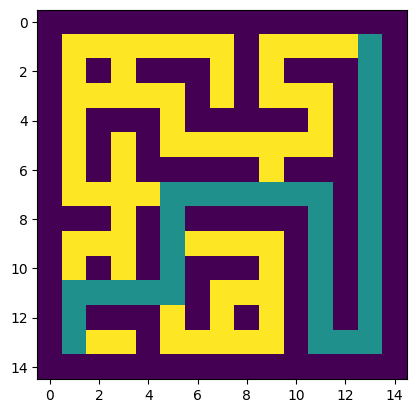

In [8]:
maze.plot(path)